# End-to-End Machine Learning Project


Following the Chapter 2 of *Hands-On Machine Learning with Scikit-learn and Tensorflow*, This exercise is done to complete an end-to-end machine learning project. The dataset used with this exercise is the California Housing Prices dataset from the StatLib Repository. Given a dataset of housing in California, we are to come up with an algorithm that can predict the housing price.



First we will fetch the data from the StatLib website:

In [1]:
import os
import tarfile
from six.moves import urllib
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH="datasets/housing"
HOUSING_URL=DOWNLOAD_ROOT+HOUSING_PATH+"/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path=os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz=tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Now having defined the fetching function, we can call it to extract the datafile in .csv 

In [2]:
fetch_housing_data(HOUSING_URL,HOUSING_PATH)

Now load the data using pandas.

In [3]:
import pandas as pd
import numpy as np

csv_path=os.path.join(HOUSING_PATH,"housing.csv")
housing = pd.read_csv(csv_path)

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


#### Some things to notice:

* The only data missing is the total_bedrooms, which here are 207 data points missing
* ocean proximity is a feature defined as an "object" but we are safe to assume that it is a string, indicating a location in reference to the ocean. (Categorical feature) Every other feature is a float value.

With that in mind, we want to look at what categories exist for the ocean proximity. We can also plot histogram to look more carefully at the statistical values of each features as shown above.

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
#%matplotlib inline
#import matplotlib.pyplot as plt
#housing.hist(bins=50,figsize=(20,10))
#plt.show()

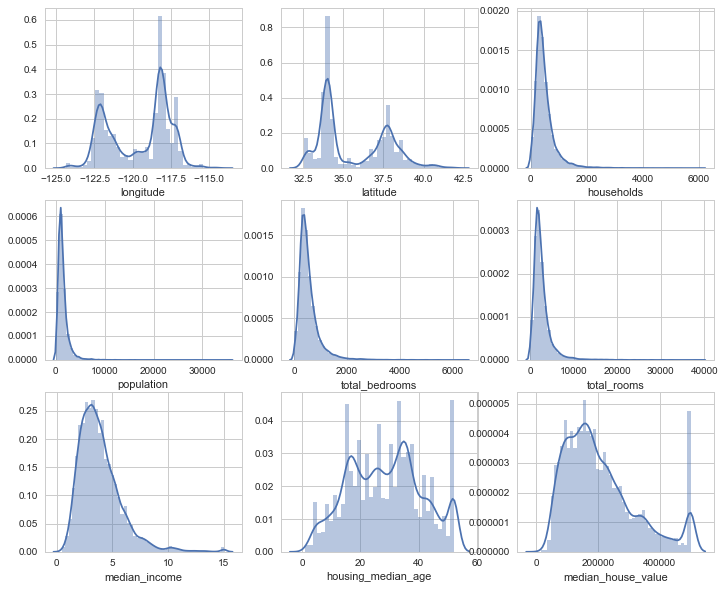

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=[12,10])
plt.subplot(331)
sns.distplot(housing['longitude'])
plt.subplot(332)
sns.distplot(housing['latitude'])
plt.subplot(333)
sns.distplot(housing['households'])
plt.subplot(334)
sns.distplot(housing['population'])
plt.subplot(335)
sns.distplot(housing['total_bedrooms'].dropna())
plt.subplot(336)
sns.distplot(housing['total_rooms'])
plt.subplot(337)
sns.distplot(housing['median_income'])
plt.subplot(338)
sns.distplot(housing['housing_median_age'])
plt.subplot(339)
sns.distplot(housing['median_house_value'])
plt.show()


#### We notice a few things about the data given the graphs:

    1. Housing value and Housing age are capped to a certain max.
    2. Median Income is definitely not in dollars (perhaps in 10000s instead).
    3. A lot of data are tail heavy.
    4. There's not much to be looking at longitudes and latitudes.
    
Now we can start testing for a model. But first we have to split the data into a training set and a test set.

In [10]:
from sklearn.model_selection import train_test_split

train,test=train_test_split(housing, test_size=0.2)
print('train set size:',len(train),', test set size:',len(test))

train set size: 16512 , test set size: 4128


In [11]:
housing['income_cat']=np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]
    

In [13]:
housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [14]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)

In [15]:
housing = strat_train_set.copy()

## Visualizing Data

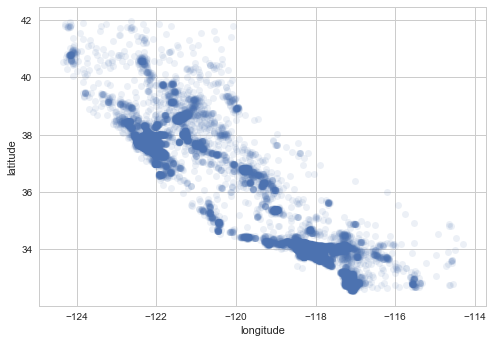

In [16]:
sns.regplot('longitude','latitude',data=housing, scatter=True, fit_reg=False, scatter_kws={'alpha':0.1})

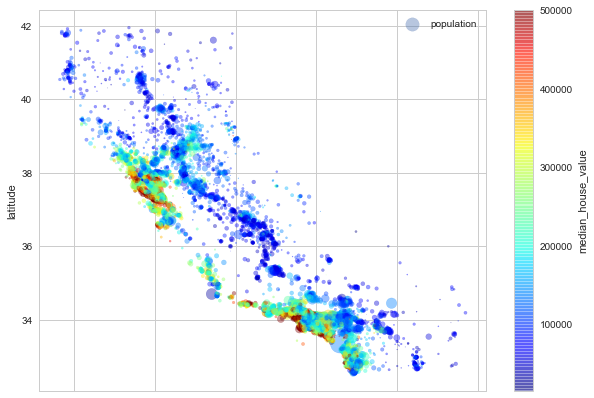

In [17]:
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=.4,s=housing['population']/100,label='population',figsize=(10,7),c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True)
plt.legend()

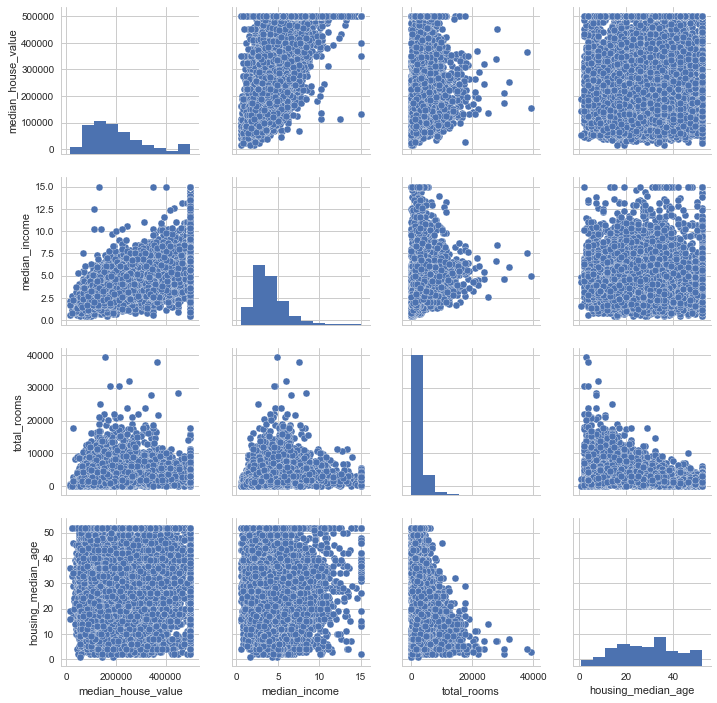

In [18]:
attributes=['median_house_value','median_income','total_rooms','housing_median_age']
sns.pairplot(housing[attributes])

### Finding Correlations

In [19]:
corr_matrix=housing.corr()

In [20]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

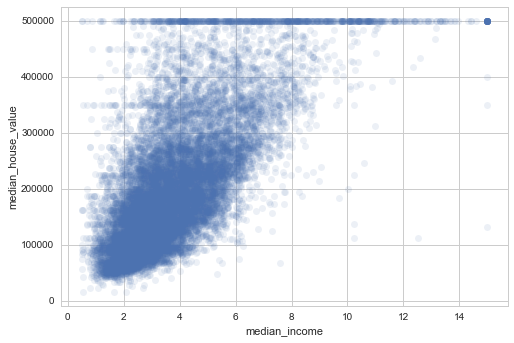

In [21]:
sns.regplot('median_income','median_house_value',data=housing, scatter=True, fit_reg=False, scatter_kws={'alpha':0.1})

## Experimenting with features to create new features that will help with our modelling.

In [22]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare our data so we can start applying ML algorithms

### Cleaning/Handling missing data

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [25]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
housing_num=housing.drop('ocean_proximity',axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [26]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [27]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [28]:
X=imputer.transform(housing_num)
housing_tr=pd.DataFrame(X,columns=housing_num.columns)

### Handling text/categorial attributes

In [29]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
housing_cat=housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [30]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot=encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### Custom Transformer

Custom transformers are useful for doing custom cleanup operations or combining specific attributes.

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [32]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### Transformation Pipeline

Pipeline is useful in executing many transformation steps (including feature scaling). Following is a small pipeline for the numerical attributes:

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

To be able to use Pandas DataFrame directly into a pipeline, we can customize a new custom transformer called *DataFrameSelector*:

In [34]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [35]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

The above code pipelined the transformers for numerical and categorical features separately. In order to combine them back together and therefore perform a fully functional pipeline, we can use Scikit-learn's *FeatureUnion* class:

In [36]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [37]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [38]:
housing_prepared.shape

(16512, 16)

## Select/Train a Model

Now we can start to train a model. Since the prediction takes on a continuous value (medium house value), we will use a basic Linear Regression model.

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data=housing.iloc[:5]
some_label=housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:",lin_reg.predict(some_data_prepared))
print("Labels:",list(some_label))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849878]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


/Users/ysjeong/Library/Python/3.5/lib/python/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


We can measure the performance of this model using Root Mean Squared Error (RMSE).

In [40]:
from sklearn.metrics import mean_squared_error
housing_predictions=lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

As we would expect from the sample prediction and label produced earlier, the RMSE on Linear Regression model is not very good. Considering the houses are priced around 120000~265000 dollars on average, an error of 68000 represents, at the lowest, 25% error. 

To solve this problem, we can either improve on the features of the data or introduce a stronger model. We will use a stronger model in this case.

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The RMSE on Decision Tree was 0 and perhaps it could be because the model *is perfect*. Or that it has overfit the data. We can remedy this problem by using a cross-validation within our training data.

### Cross Validation

We can use scikit-learn's *K-fold cross-validation* class to create a cross-validation feature.

In [42]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error',cv=10)
tree_rmse_scores = np.sqrt(-scores)

Now we can look at the results:

In [43]:
def display_scores(scores):
    print("Scores:",scores)
    print("Mean:",scores.mean())
    print("Standard Deviation",scores.std())
    
display_scores(tree_rmse_scores)

Scores: [ 70026.25761878  66273.27119847  70576.47560582  67622.03637
  72254.58656719  74644.60221135  69771.03827598  70270.41356656
  76485.10231092  70922.4359567 ]
Mean: 70884.6219682
Standard Deviation 2859.00593288


In [44]:
lin_scores = cross_val_score(lin_reg,housing_prepared,housing_labels,scoring='neg_mean_squared_error',cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70361.18285107  74742.02956966
  68022.09224176  71191.82593104  64969.63056405  68276.69992785
  71543.69797334  67665.10082067]
Mean: 69051.511639
Standard Deviation 2732.29492245


Using Cross-validation, it appears that the Decision Tree actually performs worse than the Linear Regression. We will introduce another model, called the Random Forest. It works by training many Decision Trees on random subsets of features.

In [45]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)

# find training set score
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

# find validation set scores
forest_scores = cross_val_score(forest_reg,housing_prepared,housing_labels,scoring='neg_mean_squared_error',cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

22023.131049
Scores: [ 52411.59032372  49303.35366279  52294.33623897  54173.04321819
  52857.15739334  56377.81296962  51551.19152891  50024.68374252
  54975.92115303  52151.27546344]
Mean: 52612.0365695
Standard Deviation 2034.36551825


Ramdom Forest was a lot better, but it is still overfitting the data (because validation sets scores are much higher than the training set score). We can try one other model: Support Vector Machine (SVM) in the next section.

## Fine-Tune your model

In order to fine-tune your model, you have to play around with the hyperparameters. In this section, we can explore the two kinds that scikit-learn offers: Grid Search and Randomized Search. We can use them to determine which hyperparameter gives us the best solution using SVM.

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [{'kernel':['linear'],'C':[10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
              {'kernel':['rbf'],'C':[1.0, 3.0, 10., 30., 100., 300., 1000.0],'gamma':[0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
             ]

svm = SVR()
grid_search = GridSearchCV(svm,param_grid,cv=5,scoring='neg_mean_squared_error', n_jobs=4)
grid_search.fit(housing_prepared,housing_labels)

grid_search.best_params_

### Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV